# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import datetime as dt
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

#Files
from util import fetchOnlineData, slice_df

# Initial variables

In [2]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

# Importing dataset

In [3]:
yesterday = dt.date.today() - dt.timedelta(1)
dataset = fetchOnlineData(start_d, symbol, yesterday, del_cols=False)

[*********************100%***********************]  1 of 1 downloaded


In [4]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-24,77.129997,78.879997,76.779999,77.809998,77.809998,6297000
2018-01-25,78.449997,78.989998,77.320000,78.580002,78.580002,7840100
2018-01-26,79.209999,80.449997,79.000000,80.300003,80.300003,17423400
2018-01-29,80.000000,80.430000,78.970001,79.339996,79.339996,9719600
2018-01-30,77.580002,79.269997,76.760002,78.269997,78.269997,7326500


In [5]:
df_stock = dataset.copy()
df_stock = df_stock.dropna()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]

# Data scaling

In [6]:
# data scaling (normalizing)
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# Splitting dataset

In [7]:
# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (185, 19, 4)
y_train.shape =  (185, 4)
x_valid.shape =  (23, 19, 4)
y_valid.shape =  (23, 4)
x_test.shape =  (23, 19, 4)
y_test.shape =  (23, 4)


/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# Building the model

In [8]:
# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

## Function to get the next batch

In [9]:

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

## Layers

In [10]:
#RNN 
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#        for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)] 


Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [11]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

## Cost function

In [12]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

## Optimizer

In [13]:
#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

## Fitting the model

In [14]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
    # Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})            

0.00 epochs: MSE train/valid = 0.583038/0.358297
4.86 epochs: MSE train/valid = 0.010688/0.013252
9.73 epochs: MSE train/valid = 0.006446/0.007516
14.59 epochs: MSE train/valid = 0.004201/0.007354
19.46 epochs: MSE train/valid = 0.004620/0.007406
24.32 epochs: MSE train/valid = 0.004309/0.006908
29.19 epochs: MSE train/valid = 0.004559/0.005899
34.05 epochs: MSE train/valid = 0.004647/0.005760
38.92 epochs: MSE train/valid = 0.002736/0.004947
43.78 epochs: MSE train/valid = 0.003020/0.005020
48.65 epochs: MSE train/valid = 0.002545/0.004744
53.51 epochs: MSE train/valid = 0.002227/0.004331
58.38 epochs: MSE train/valid = 0.002700/0.004316
63.24 epochs: MSE train/valid = 0.002217/0.004279
68.11 epochs: MSE train/valid = 0.001991/0.004224
72.97 epochs: MSE train/valid = 0.001958/0.004158
77.84 epochs: MSE train/valid = 0.001938/0.004041
82.70 epochs: MSE train/valid = 0.002005/0.003974
87.57 epochs: MSE train/valid = 0.001943/0.004048
92.43 epochs: MSE train/valid = 0.001733/0.003873
97.

# Predictions

In [15]:

    
#checking prediction output nos 
y_test_pred.shape

(23, 4)

# Plotting the graph

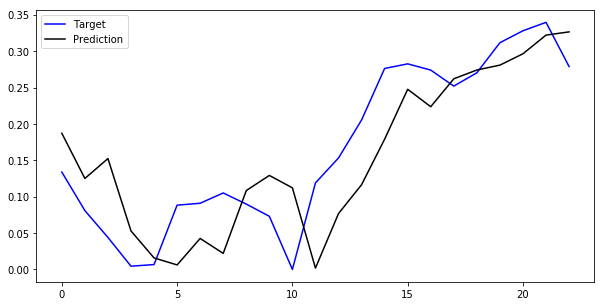

In [16]:
# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()